# DNN Learning Graph

## Imports & initialization

In [141]:
# import the libraries we will use
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
# an utility function to plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [143]:
# internalize the dataset
df = pd.read_csv('Churn.csv')

### Split & Rescale

In [144]:
x_data = df.drop(['Exited'],axis=1)
y_val = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(x_data,y_val,test_size=0.3,random_state=101)

In [145]:
# Get around a bug in Sklearn / Pandas communication
# see https://stackoverflow.com/questions/45090639/pandas-shows-settingwithcopywarning-after-train-test-split
X_train.is_copy=None
X_test.is_copy=None

In [146]:
cols_to_scale=['CreditScore','Tenure','Balance','NumOfProducts','EstimatedSalary']
for col in cols_to_scale:
    xmin=X_train[col].min()
    dx=X_train[col].max()-xmin
    X_train[[col]] = X_train[[col]].apply(lambda x: ((x - xmin) / dx))
    X_test[[col]] = X_test[[col]].apply(lambda x: ((x - xmin) / dx))

## Create the tensorflow estimator

### Create the 'feature columns'

In [147]:
# create the numeric columns
age = tf.feature_column.numeric_column('Age')
creditscore = tf.feature_column.numeric_column('CreditScore')
tenure = tf.feature_column.numeric_column('Tenure')
balance = tf.feature_column.numeric_column('Balance')
numproducts = tf.feature_column.numeric_column('NumOfProducts')
hascard = tf.feature_column.numeric_column('HasCrCard')
isactive = tf.feature_column.numeric_column('IsActiveMember')
estimated = tf.feature_column.numeric_column('EstimatedSalary')

In [148]:
# create categorical columns
geography = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key='Geography',vocabulary_list=df['Geography'].unique()))
gender = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key='Gender',vocabulary_list=df['Gender'].unique()))

In [149]:
# Discretize the age column 
age_b = tf.feature_column.bucketized_column(age, boundaries=[20,30,40,50,60,70,80])

In [150]:
feat_cols = [age_b,creditscore,tenure,balance,numproducts,hascard,isactive,estimated,geography,gender ]

### Create the input functions

In [151]:
train_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)

In [152]:
test_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      num_epochs=1,
      shuffle=False)

In [153]:
valid_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_train,
      num_epochs=1,
      shuffle=False)

### Create the estimator 

In [154]:
model = tf.estimator.DNNClassifier(hidden_units=[8],feature_columns=feat_cols,n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': 1, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_session_config': None, '_log_step_count_steps': 100, '_model_dir': '/var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmpdtvym8al', '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None}


In [155]:
#reset errors 
err=[]
err2=[]

### Training loop

In [ ]:
for i in range(1,101):
    #train
    model.train(input_fn=train_input_fn,steps=700)
    #test and get the confusion matrix on test
    predictions = list(model.predict(test_input_func))
    y_pred = []
    for p in predictions:
        y_pred.append(p['class_ids'][0])
    cmp=confusion_matrix(y_test, y_pred)
    err.append((cmp[0,1]+cmp[1,0])/30)
    #Get it on the training set
    predictions2 = list(model.predict(valid_input_func))
    y_pred2 = []
    for p in predictions2:
        y_pred2.append(p['class_ids'][0])
    cmp2=confusion_matrix(y_train, y_pred2)
    err2.append((cmp2[0,1]+cmp2[1,0])/70)

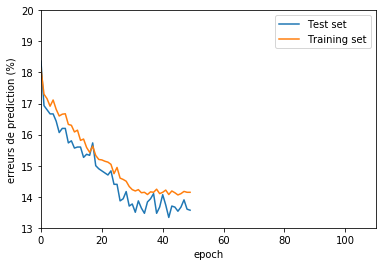

In [140]:
# Plot the learning progress
plt.plot(err,label="Test set")
plt.plot(err2,label="Training set")
plt.autoscale(True)
plt.xlabel("epoch")
plt.ylabel("erreurs de prediction (%)")
plt.legend()
plt.xlim(0,110)
plt.ylim(13,20)
plt.autoscale(False)

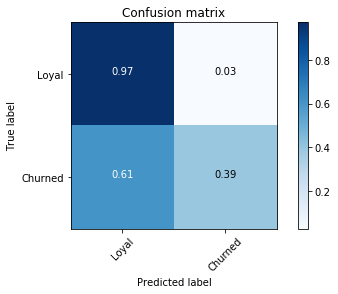

In [74]:
plot_confusion_matrix(cmp,True)